In [1]:
import torch
from heat_solver import HeatSolver, solve_heat_equation
from inverse_solver import InverseSolver
from utils import (
    create_conductivity_field,
    _boundary_mask,
    sine_source,
    sine_gauss_source,
    sine_sine_source,
    sine_cosine_source,
    compute_l2_error,
    r2_score,
    visualize_solution,
    compute_relative_error
)

from utils import verification_source, verification_solution

from utils import SimpleSigma, SigmoidSigma

from run import get_boundary_conditions

## Test loss

In [2]:
# === Params ===
M = 10
T = 1.0
device = 'cpu'
max_sigma = 5
alpha = 0.000
sigma_0 = 1.0  # Initial guess
lr = 1e-1
omega = 2.0 * 3.1415   # Frequency for sine source
noise_level = 0.0000
max_iters = 5000
tol = 1e-3
pattern = 'constant'

source_func = lambda x, y, t: sine_cosine_source(x, y, t, omega)
sigma_gt = create_conductivity_field(M, pattern=pattern, device=device)

In [3]:
# Generate boundary observations with noise
u_b_gt = get_boundary_conditions(sigma_gt, source_func, T, max_sigma, device=device)
u_b = (1 + noise_level * torch.randn_like(u_b_gt)) * u_b_gt

In [4]:
sigma = SimpleSigma(M, sigma_0)

In [5]:
torch.max(sigma())

tensor(1.2169, grad_fn=<MaxBackward1>)

In [10]:
solver = HeatSolver(M, source_func, device)
_, u_b_history, u_history = solver(2*sigma(), T, max_sigma=max_sigma)

In [11]:
print(solver.h, solver.tau)

0.1 0.00025


In [12]:
print((u_b_history - u_b).square().mean())

tensor(0.0004, grad_fn=<MeanBackward0>)


In [20]:
torch.mean(u_b[2000].abs()).square()

tensor(0.0015)

In [15]:
print((u_b_history - u_b).square().mean() / torch.mean(u_b.abs()).square())

tensor(0.4423, grad_fn=<DivBackward0>)


In [13]:
loss_data = solver.h * solver.tau * (u_b_history - u_b).square().sum()
print(loss_data)

tensor(0.0014, grad_fn=<MulBackward0>)


In [10]:
# Inverse solver
inverse_solver = InverseSolver(
    sigma,
    u_b_gt=u_b,
    source_func=source_func,
    M=M,
    T=T,
    n_steps=u_b.shape[0] - 1,
    alpha=alpha,
    sigma_0=sigma_0,
    device=device
)

KeyboardInterrupt: 

In [ ]:
final_sigma, total_loss_history, boundary_loss_history, regularization_loss_history = inverse_solver.solve(
    max_iters=max_iters,
    tol=tol,
    print_info=False
)

  0%|          | 0/5000 [00:00<?, ?it/s]

1.0 16000


  0%|          | 0/5000 [00:25<?, ?it/s]

Converged at iteration 0, loss: 0.000000


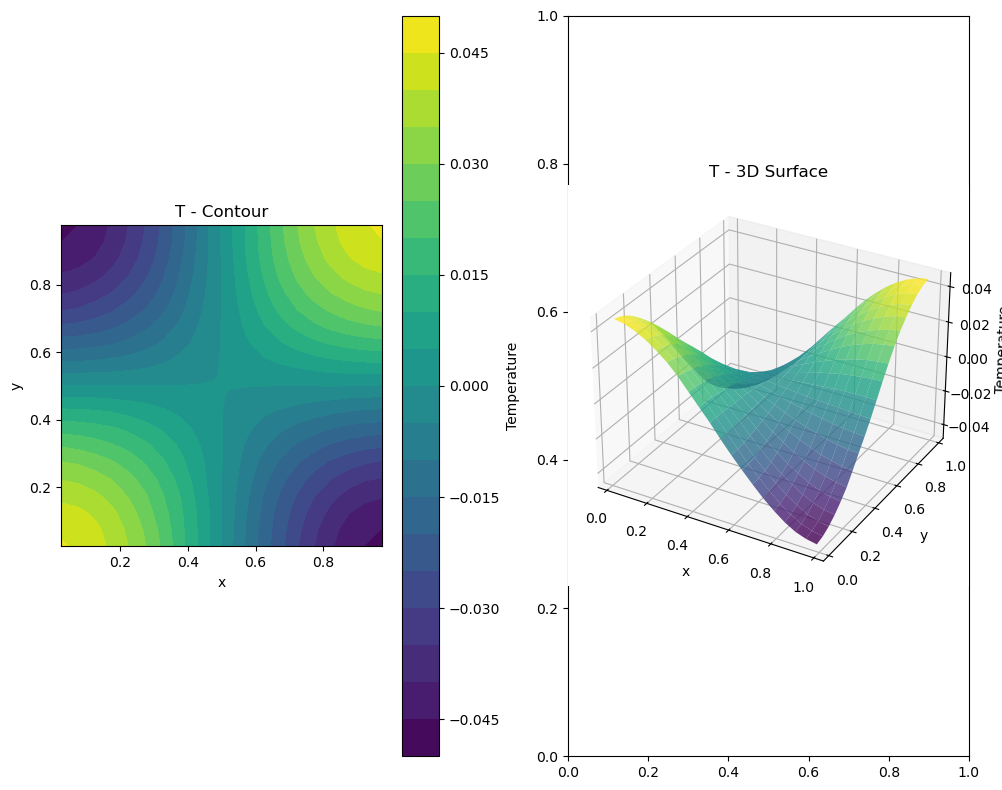

In [9]:
h = 1.0 / M
x = torch.linspace(0, 1, M+1, device=device)[:-1] + h/2
y = torch.linspace(0, 1, M+1, device=device)[:-1] + h/2
X, Y = torch.meshgrid(x, y, indexing='ij')

visualize_solution(u_history[-10000].detach().numpy(), X.detach().numpy(), Y.detach().numpy(), "T")

In [10]:
f = source_func(X, Y, 0.7).detach().numpy()

In [11]:
import numpy as np

In [12]:
np.max(f)

0.048682038

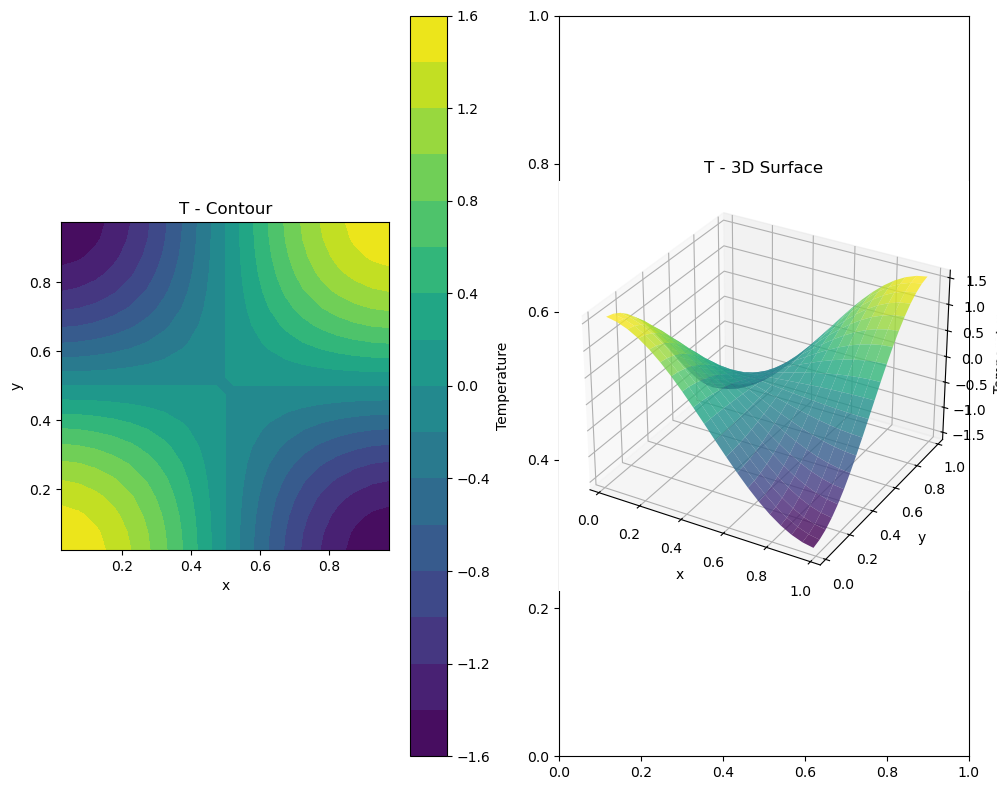

In [13]:
h = 1.0 / M
x = torch.linspace(0, 1, M+1, device=device)[:-1] + h/2
y = torch.linspace(0, 1, M+1, device=device)[:-1] + h/2
X, Y = torch.meshgrid(x, y, indexing='ij')

visualize_solution(source_func(X, Y, 0.1).detach().numpy(), X.detach().numpy(), Y.detach().numpy(), "T")

In [24]:
print(r2(sigma_gt, sigma_0))

-6.015038013458252


In [64]:
print((final_sigma - sigma_0).square().mean())

tensor(0.0097, grad_fn=<MeanBackward0>)


In [27]:
u_b_2 = get_boundary_conditions(1.5*final_sigma, source_func, T, max_sigma, device=device)

In [28]:
print((u_b_2 - u_b_gt).square().sum())

tensor(0., grad_fn=<SumBackward0>)


In [34]:
torch.max(u_b_gt), torch.min(u_b_gt)

(tensor(0.3183), tensor(0.))